In [47]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas_ta as pdta
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
os.chdir(r'C:\Users\donov\Downloads\Northwestern\MSDS 451 - Financial ML\Anaconda Working Dir')
import itertools
from itertools import product
import seaborn as sns

In [2]:

np.random.seed(0)
# Fractional differntiation code snippets from Dr. Ernie P Chan and Dr. Roger Hunter
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x=pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x=x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df   

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

In [3]:

def create_full_dataset(df):
    df['Index'] = pd.to_numeric(df['Index'], errors='coerce')
    df['Index'] = df['Index'].astype(float, errors='raise')
    df['dfy'] = df['BAA'] - df['AAA'] 
    df['dfr'] = df['corpr'] - df['lty'] 
    df['d/p'] = np.log(df['D12'].astype('float32')) - np.log(df['Index'].astype('float32') )
    df['d/y'] = np.log(df['D12']) - np.log(df['Index'].shift(-1))
    df['e/p'] = np.log(df['E12']) - np.log(df['Index'] )
    df['e10/p'] = np.log(pdta.sma(df['D12'],10)) - np.log(df['Index'])
    df['tms'] = df['lty'] - df['tbl'] 
    df['excess returns'] = df['CRSP_SPvw'] - df['Rfree'] 
    df.dropna(how='all', inplace=True)
    return df


        

In [4]:
def fractional_diff(df):
    fract_dict = dict()
    for col in list(df.columns[1:]):
        fract_dict[str(col)] = round(findMinD(pd.DataFrame(df[col])),3)
    for col, fract_diff in fract_dict.items():
        if fract_diff > 0:
            df[col] = fracDiff_FFD(pd.DataFrame(df[col]),fract_diff, 0.01)
            print(f'Fractionally Diffed {col}, using {fract_diff}')
    return df

    

In [5]:
# define imputer
def impute(df):
    imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    imputer.fit(df.iloc[:,1:])
    imputed = imputer.transform(df.iloc[:,1:])
    imputed = pd.concat([df.iloc[:,0:1],pd.DataFrame(imputed)], axis=1)
    imputed.columns = df.columns
    df = imputed.copy()
    return df

In [6]:
def log_dataset(df):
    df.loc[:, ~df.columns.isin(['d/y', 'd/p','e/p', 'e10/p','excess returns'])] = np.log(df.loc[:, ~df.columns.isin(['d/y', 'd/p','e/p', 'e10/p', 'excess returns'])])
    df.iloc[:,:1] = np.e**(df.iloc[:,:1])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    
    plt.xlabel('predicted label')
    


# Question 1
You will need to refer to: Goyal, Amit, and Ivo Welch.  “A Comprehensive Look at the Empirical Performance of Equity Premium PredictionLinks to an external site..” The Review of Financial Studies 21, no. 4 (2008): 1455–1508 for the accompanying paper that explains what the features are. 
Download Goyal's dataset that is referenced in the article from his University of Lausanne Faculty website (Links to an external site.). On his page, locate the link titled "Updated data (up to 2019) (except variable lty)", or simply download the Excel spreadsheet directly using the following link PredictorData2019.xlsx (Links to an external site.)

Create appropriate labels and perform EDA on it. Are there any outliers? (2 pt)

## Answer: 
Yes there are quite a few outliers

In [8]:
# read in data

monthly_df = pd.read_csv('Monthly.csv')
monthly_df.name = "Monthly"
monthly_df = create_full_dataset(monthly_df)
monthly_y = monthly_df['CRSP_SPvw'] - monthly_df['Rfree'] 

quarterly_df= pd.read_csv('Quarterly.csv')
quarterly_df = create_full_dataset(quarterly_df)
quarterly_df.name = "Quarterly"
quarterly_y = quarterly_df['CRSP_SPvw'] - quarterly_df['Rfree'] 

annual_df= pd.read_csv('Annual.csv')
annual_df.name = "Annual"
annual_df = create_full_dataset(annual_df)
annual_y = annual_df['CRSP_SPvw'] - annual_df['Rfree'] 

df_list= [monthly_df, quarterly_df, annual_df]

In [9]:
# Create additional features from paper

monthly_df = create_full_dataset(monthly_df)
quarterly_df = create_full_dataset(quarterly_df)
annual_df = create_full_dataset(annual_df)

In [10]:
# Descriptive statistics of each field
for df in df_list:
    display(df.describe())

,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,...,CRSP_SPvw,CRSP_SPvwx,dfy,dfr,d/p,d/y,e/p,e10/p,tms,excess returns
count,1800.000000,1551.000000,1800.000000,1800.000000,1198.000000,1212.000000,1224.000000,1224.000000,1224.000000,1129.000000,...,1140.000000,1140.000000,1224.000000,1140.000000,1551.000000,1550.000000,1551.000000,1542.000000,1212.000000,1140.000000
mean,194556.500000,85.043475,6.561882,14.980376,0.555927,0.033741,0.056944,0.068724,0.049775,0.016223,...,0.009535,0.006390,0.011779,-0.044862,-3.104491,-3.107235,-2.614632,-3.117016,0.016058,0.006829
std,4331.235457,174.621099,11.722141,28.155466,0.260371,0.029781,0.026760,0.028352,0.027023,0.025862,...,0.054190,0.054264,0.006929,0.034715,0.322181,0.325143,0.347184,0.335161,0.012947,0.054293
min,187101.000000,2.730000,0.180000,0.160000,0.120510,0.000100,0.021400,0.029400,0.006200,-0.055953,...,-0.287461,-0.291524,0.003200,-0.210100,-4.144099,-4.147192,-4.836482,-4.159463,-0.036500,-0.287761
25%,190806.750000,6.805000,0.420000,0.556700,0.333668,0.008000,0.036500,0.048300,0.028475,0.004426,...,-0.016768,-0.019097,0.007100,-0.063600,-3.317100,-3.325957,-2.837812,-3.347448,0.006775,-0.019661
50%,194556.500000,12.190000,0.861650,1.443500,0.530629,0.030150,0.049500,0.062700,0.042150,0.016454,...,0.013000,0.009393,0.009500,-0.036650,-3.092129,-3.094201,-2.629831,-3.106747,0.016100,0.010078
75%,198306.250000,87.185000,6.945000,14.690025,0.732941,0.050550,0.073500,0.083825,0.064825,0.027176,...,0.038728,0.035741,0.014325,-0.022000,-2.892008,-2.888172,-2.397381,-2.898827,0.025300,0.035587
max,202012.000000,995.970000,59.683400,139.470000,2.028478,0.163000,0.154900,0.171800,0.148200,0.177040,...,0.414312,0.412291,0.056400,0.125700,-1.873246,-1.835242,-1.670063,-1.728904,0.045500,0.413312


,yyyyq,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,...,D3,E3,dfy,dfr,d/p,d/y,e/p,e10/p,tms,excess returns
count,600.000000,517.000000,600.000000,600.000000,400.000000,404.000000,408.000000,408.000000,408.000000,2.760000e+02,...,132.000000,344.000000,408.000000,380.000000,517.000000,516.000000,517.000000,508.000000,404.000000,380.000000
mean,19457.500000,85.483230,6.594158,15.032498,0.559286,0.033743,0.056938,0.068758,0.049680,1.449271e-12,...,6.317886,6.572939,0.011821,-0.034064,-3.103630,-3.111864,-2.614176,-3.139698,0.015958,0.021690
std,433.365811,175.678651,11.791596,28.252690,0.262643,0.029866,0.026737,0.028358,0.027118,3.039399e-02,...,3.609074,8.788987,0.007013,0.048982,0.325758,0.334959,0.352355,0.356898,0.012920,0.111613
min,18711.000000,2.730000,0.180000,0.160000,0.125209,0.000100,0.022600,0.029400,0.006800,-2.727719e-01,...,2.243000,-23.250000,0.003400,-0.256025,-4.137093,-4.147732,-4.807399,-4.194303,-0.035000,-0.393700
25%,19082.750000,6.810000,0.420000,0.558750,0.337736,0.007850,0.036475,0.048400,0.028400,-1.744528e-02,...,3.609500,0.737500,0.007175,-0.054961,-3.320228,-3.338895,-2.836288,-3.399473,0.006775,-0.027862
50%,19457.500000,12.250000,0.865000,1.445000,0.530910,0.029800,0.049500,0.062650,0.042000,7.119884e-03,...,4.969000,2.665000,0.009550,-0.025223,-3.093154,-3.101789,-2.630289,-3.118906,0.016000,0.031602
75%,19832.250000,86.160000,6.955000,14.632500,0.733837,0.050725,0.073350,0.083925,0.065025,1.873421e-02,...,7.816750,9.182500,0.014325,-0.008978,-2.886819,-2.893526,-2.399702,-2.904627,0.025300,0.073548
max,20204.000000,995.970000,59.683400,139.470000,2.028478,0.154900,0.154900,0.169200,0.148200,4.289678e-02,...,15.323000,36.360000,0.055900,0.203287,-1.903915,-1.789505,-1.670063,-1.613283,0.045300,0.892863


,yyyy,Index,D12,E12,b/m,tbl,AAA,BAA,lty,cay,...,CRSP_SPvw,CRSP_SPvwx,dfy,dfr,d/p,d/y,e/p,e10/p,tms,excess returns
count,150.000000,129.000000,150.000000,150.000000,100.000000,101.000000,102.000000,102.000000,102.000000,7.600000e+01,...,95.000000,95.000000,102.000000,95.000000,129.000000,128.000000,129.000000,120.000000,101.000000,95.000000
mean,1945.500000,86.398062,6.736647,15.327473,0.545857,0.033942,0.056601,0.068944,0.049016,-2.631580e-12,...,0.120284,0.079226,0.012343,0.015603,-3.104673,-3.138530,-2.618865,-3.265555,0.015074,0.086026
std,43.445368,178.143134,12.084529,28.809147,0.258822,0.029978,0.026429,0.028340,0.026426,3.216887e-02,...,0.196857,0.190572,0.007661,0.084921,0.326844,0.362265,0.351736,0.378349,0.013762,0.199750
min,1871.000000,3.250000,0.180000,0.160000,0.131218,0.000100,0.022600,0.031000,0.009300,-1.610835e-01,...,-0.455253,-0.489204,0.003400,-0.149604,-4.137093,-4.176445,-4.105981,-4.332914,-0.035000,-0.464935
25%,1908.250000,6.810000,0.422500,0.542500,0.334782,0.009000,0.037600,0.048500,0.027450,-1.750053e-02,...,-0.014059,-0.059291,0.007425,-0.038972,-3.333825,-3.397848,-2.849550,-3.561000,0.005300,-0.031793
50%,1945.500000,12.490000,0.890000,1.570000,0.518685,0.030400,0.049850,0.062750,0.042000,1.700785e-03,...,0.144510,0.109119,0.009850,0.012698,-3.106414,-3.142259,-2.630289,-3.277066,0.015500,0.105198
75%,1982.750000,90.190000,7.035000,14.767500,0.721622,0.050700,0.072075,0.084275,0.063675,2.081718e-02,...,0.265730,0.217835,0.014775,0.061770,-2.902206,-2.902900,-2.404314,-2.984235,0.024600,0.224400
max,2020.000000,970.430000,58.279000,139.470000,1.442084,0.154900,0.142300,0.165500,0.133400,7.158899e-02,...,0.532512,0.472273,0.051000,0.316119,-2.287986,-2.114533,-1.670063,-2.250276,0.045300,0.528786


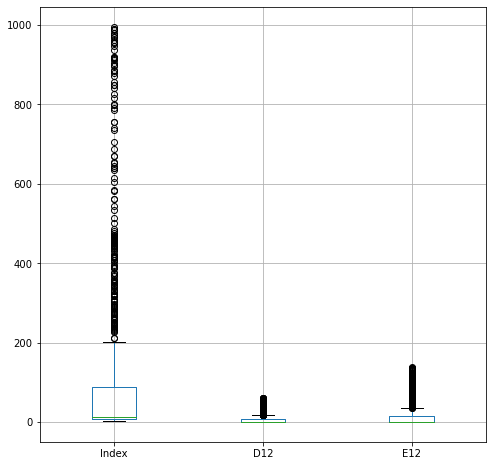

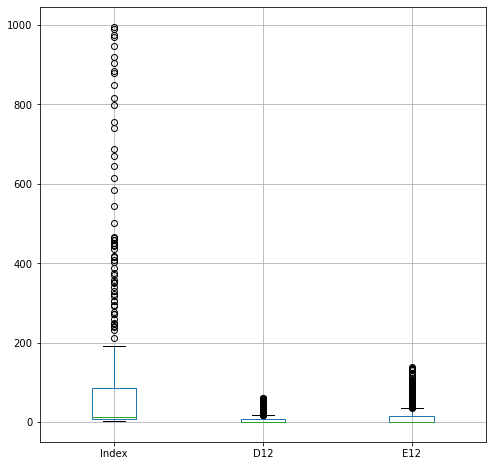

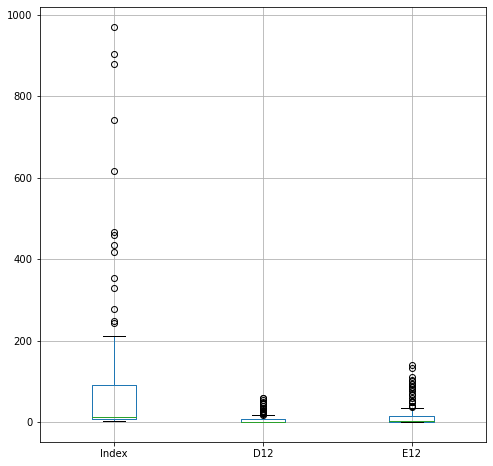

In [11]:
# Plotting first four features
for df in df_list:
    plt.figure(figsize=(8,8))
    df.iloc[:,1:4].boxplot()
    plt.show();

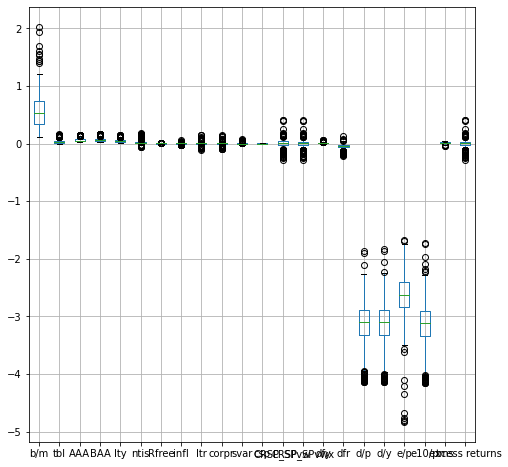

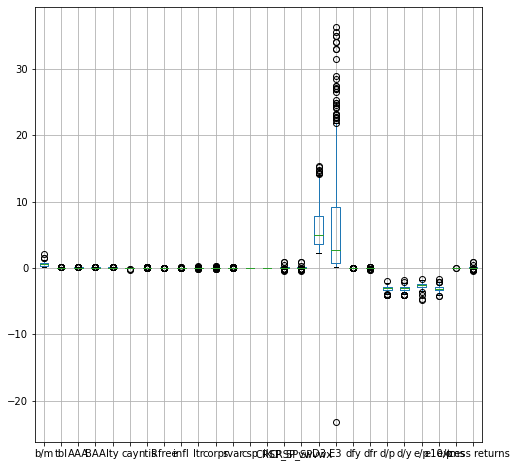

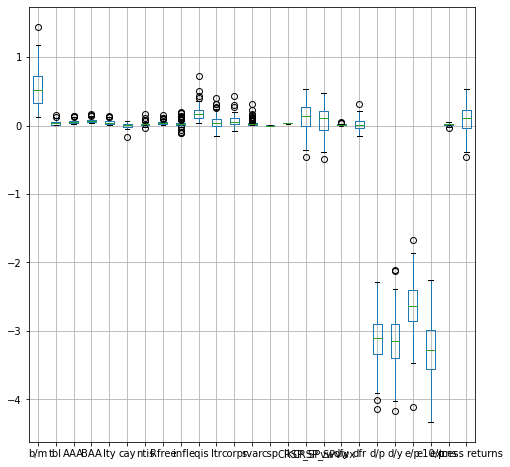

In [12]:
# plot remaining features
for df in df_list:
    plt.figure(figsize=(8,8))
    df.iloc[:,4:].boxplot()
    plt.show();

In [13]:
from scipy import stats
monthly_df[(np.abs(stats.zscore(monthly_df)) < 1.5)]

C:\Users\donov\anaconda3\envs\tflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,...,CRSP_SPvw,CRSP_SPvwx,dfy,dfr,d/p,d/y,e/p,e10/p,tms,excess returns
0,187101.0,4.44,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.837728,-2.851151,-2.406945,NaN,NaN,NaN
0,187101.0,4.44,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.837728,-2.851151,-2.406945,NaN,NaN,NaN
1,187102.0,4.50,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.851151,-2.875302,-2.420368,NaN,NaN,NaN
1,187102.0,4.50,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.851151,-2.875302,-2.420368,NaN,NaN,NaN
2,187103.0,4.61,0.2600,0.4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.875302,-2.903111,-2.444519,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,201101.0,NaN,22.9630,78.6700,0.348632,0.0015,0.0504,0.0609,0.0432,0.015368,...,0.023349,0.022319,0.0105,-0.0630,NaN,NaN,NaN,NaN,0.0417,0.023249
1681,201102.0,NaN,23.1970,79.9900,0.339097,0.0013,0.0522,0.0615,0.0426,0.015918,...,0.032508,0.030251,0.0093,-0.0269,NaN,NaN,NaN,NaN,0.0413,0.032408
1682,201103.0,NaN,23.4310,81.3100,0.354270,0.0010,0.0513,0.0603,0.0429,0.012476,...,0.000625,-0.000867,0.0090,-0.0501,NaN,NaN,NaN,NaN,0.0419,0.000525
1683,201104.0,NaN,23.7343,82.1633,0.340697,0.0006,0.0516,0.0602,0.0416,0.009381,...,0.029441,0.028358,0.0086,-0.0177,NaN,NaN,NaN,NaN,0.0410,0.029441


In [14]:
# Number of outliers in each field
for df in df_list:
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    display(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum())

yyyymm              0
Index             172
D12               210
E12               255
b/m                10
tbl                26
AAA                26
BAA                40
lty                36
ntis               57
Rfree              46
infl               98
ltr                82
corpr             104
svar              177
csp                 0
CRSP_SPvw          45
CRSP_SPvwx         45
dfy                55
dfr                35
d/p                29
d/y                25
e/p                12
e10/p              27
tms                 5
excess returns     45
dtype: int64

yyyyq              0
Index             58
D12               70
E12               86
b/m                3
tbl                8
AAA               10
BAA               14
lty               10
cay                3
ntis              22
Rfree             14
infl              30
ltr               24
corpr             30
svar              59
csp                0
ik                 0
CRSP_SPvw         16
CRSP_SPvwx        18
D3                 7
E3                32
dfy               19
dfr               20
d/p                8
d/y                9
e/p                5
e10/p              6
tms                2
excess returns    16
dtype: int64

yyyy               0
Index             14
D12               18
E12               22
b/m                1
tbl                2
AAA                3
BAA                3
lty                3
cay                1
ntis               5
Rfree              5
infl              19
eqis               4
ltr                5
corpr              3
svar              14
csp                0
ik                 0
CRSP_SPvw          1
CRSP_SPvwx         1
dfy                4
dfr                1
d/p                2
d/y                3
e/p                2
e10/p              0
tms                1
excess returns     1
dtype: int64

# Question 2 

Are there any features that are not stationary? If so, fractionally differentiate them. (2 pt)

# Answer:
Please see below

In [15]:
# check for non-stationarity and fractionally diff if needed
print('Monthly')
monthly_df_fractional = fractional_diff(monthly_df)
print('\nQuarterly')
quarterly_df_fractional  = fractional_diff(quarterly_df)
print('\nAnnually')
annual_df_fractional = fractional_diff(annual_df)


Monthly
Fractionally Diffed Index, using 0.7
Fractionally Diffed D12, using 1.0
Fractionally Diffed E12, using 0.5
Fractionally Diffed tbl, using 0.1
Fractionally Diffed AAA, using 0.3
Fractionally Diffed BAA, using 0.3
Fractionally Diffed lty, using 0.3
Fractionally Diffed csp, using 0.1
Fractionally Diffed d/y, using 0.1
Fractionally Diffed e/p, using 0.3

Quarterly
Fractionally Diffed Index, using 0.7
Fractionally Diffed D12, using 1.0
Fractionally Diffed E12, using 0.3
Fractionally Diffed b/m, using 0.1
Fractionally Diffed tbl, using 0.1
Fractionally Diffed AAA, using 0.4
Fractionally Diffed BAA, using 0.4
Fractionally Diffed lty, using 0.3
Fractionally Diffed cay, using 0.1
Fractionally Diffed csp, using 0.1
Fractionally Diffed D3, using 0.7
Fractionally Diffed E3, using 0.2
Fractionally Diffed e/p, using 0.2

Annually
Fractionally Diffed Index, using 0.8
Fractionally Diffed D12, using 0.8
Fractionally Diffed E12, using 0.2
Fractionally Diffed b/m, using 0.1
Fractionally Diffed tb

In [16]:
# log all fields that aren't already log transformed and excluding date
monthly_df_log = log_dataset(monthly_df_fractional)
quarterly_df_log = log_dataset(quarterly_df_fractional)
annual_df_log = log_dataset(annual_df_fractional)

#impute all missing values 
monthly_df_complete = impute(monthly_df_log)
quarterly_df_complete = impute(quarterly_df_log)
annual_df_complete = impute(annual_df_log)

C:\Users\donov\anaconda3\envs\tflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\donov\anaconda3\envs\tflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
C:\Users\donov\anaconda3\envs\tflow2\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


# Question 3
Use the first two-thirds of the data as the train set, setting your random seed to 1, and train a random forest using Scikit-learn’s RandomForestClassifier using the default hyperparameters. 

What is the predictive accuracy, F1, and AUC score on the train set and the test set? (3 pt)

## Answer: 
Please see below

In [17]:
# Train/test split at 2/3

month_split = int(monthly_df_complete.shape[0]//1.5)
quarter_split = int(quarterly_df_complete.shape[0]//1.5)
annual=split = int(annual_df_complete.shape[0]//1.5)


monthly_train = monthly_df_complete.iloc[:month_split, :-1]
monthly_test = monthly_df_complete.iloc[month_split:, :-1]
monthly_y_train = monthly_df_complete.iloc[:month_split, -1]
monthly_y_test = monthly_df_complete.iloc[month_split:, -1]

quarterly_train = quarterly_df_complete.iloc[:month_split, :-1]
quarterly_test = quarterly_df_complete.iloc[month_split:, :-1]
quarterly_y_train = quarterly_df_complete.iloc[:month_split, -1]
quarterly_y_test = quarterly_df_complete.iloc[month_split:, -1]

annual_train = annual_df_complete.iloc[:month_split, :-1]
annual_test = annual_df_complete.iloc[month_split:, :-1]
annual_y_train = annual_df_complete.iloc[:month_split, -1]
annual_y_test = annual_df_complete.iloc[month_split:, -1]


In [18]:
#Removed data from earlier than 1926 per the paper
########################## taking out before 1926
mask = monthly_train[monthly_train['yyyymm']>192601].index
monthly_train = monthly_train.loc[mask]
monthly_y_train = monthly_y_train.loc[mask]
####################################################################

It appears that monthly excess returns are approximately normal about a mean of zero

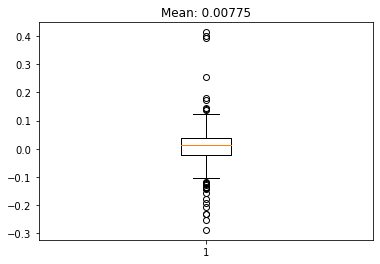

In [19]:

plt.boxplot(monthly_y_train)
plt.title(f'Mean: {round(np.mean(monthly_y_train), 5)}');

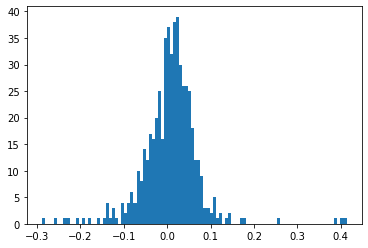

In [20]:
plt.hist(monthly_y_train, bins=100);

I chose to bin data into five categories with the intent to ignore the central class because it wouldn't likely be worthwhile to trade on slight up or down months. However, it would be good to know if there were moderate or large swings in either direction in order to position accordingly

To get a decent balance, I used a large, odd K value for uniform bins and "rolled up" the classes on the tails of the distribution

In [21]:
est = KBinsDiscretizer(n_bins=27, encode='ordinal', strategy='uniform')
est.fit(np.array(monthly_y_train).reshape(-1, 1))
monthly_y_star_train = est.transform(np.array(monthly_y_train).reshape(-1, 1))
monthly_y_star_train = pd.DataFrame(monthly_y_star_train)
monthly_y_star_train.value_counts()

11.0    133
12.0    110
10.0     88
13.0     59
9.0      55
8.0      28
14.0     17
7.0      14
15.0      9
5.0       5
6.0       5
26.0      3
16.0      3
4.0       2
3.0       2
2.0       2
20.0      1
17.0      1
18.0      1
1.0       1
0.0       1
dtype: int64

There's still some that can be addressed with other methods - it's pretty close

In [22]:
monthly_y_star_train[monthly_y_star_train<9] = 8
monthly_y_star_train[monthly_y_star_train>11] = 12

#monthly_y_star_train[monthly_y_star_train<10] = 9
#monthly_y_star_train[monthly_y_star_train>10] = 11

monthly_y_star_train.value_counts()


12.0    204
11.0    133
10.0     88
8.0      60
9.0      55
dtype: int64

In [23]:
#est = KBinsDiscretizer(n_bins=27, encode='ordinal', strategy='uniform')
#est.fit(np.array(monthly_y_test).reshape(-1, 1))
monthly_y_star_test = est.transform(np.array(monthly_y_test).reshape(-1, 1))
monthly_y_star_test = pd.DataFrame(monthly_y_star_test)
monthly_y_star_test.value_counts()

11.0    174
10.0    127
12.0    116
9.0      55
13.0     51
8.0      26
14.0     16
7.0      16
15.0      8
6.0       5
16.0      2
17.0      1
5.0       1
4.0       1
2.0       1
dtype: int64

In [24]:
monthly_y_star_test[monthly_y_star_test<9] = 8
monthly_y_star_test[monthly_y_star_test>11] = 12

#monthly_y_star_test[monthly_y_star_test<10] = 9
#monthly_y_star_test[monthly_y_star_test>10] = 11

monthly_y_star_test.value_counts()


12.0    194
11.0    174
10.0    127
9.0      55
8.0      50
dtype: int64

Untuned Hyperparmeters 
Train F1: 0.2609196776238341, Test F1: 0.19487216988053943
One-vs-One Test ROC AUC scores:
0.545810 (macro), 0.534259 (weighted by prevalence)
One-vs-Rest Test ROC AUC scores:
0.535582 (macro),0.509674 (weighted by prevalence)


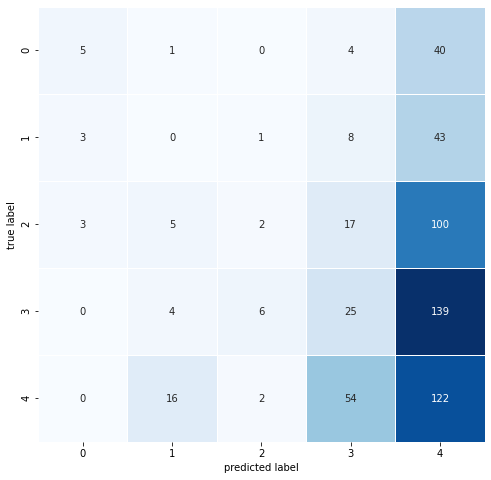

In [87]:

rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(monthly_train[:-1],np.array(monthly_y_star_train.iloc[1:]).ravel())
no_tune_monthly_y_hat_test = rf.predict(monthly_test)
no_tune_monthly_y_hat_train = rf.predict(monthly_train)
no_tune_test_f1 = f1_score(monthly_y_star_test, no_tune_monthly_y_hat_test, average='weighted')
no_tune_train_f1 = f1_score(monthly_y_star_train, no_tune_monthly_y_hat_train, average='weighted')
y_prob = rfclf.predict_proba(monthly_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(monthly_y_star_test).ravel(), y_prob, multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                     y_prob, 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                  y_prob, 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                     y_prob, 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {no_tune_train_f1}, Test F1: { no_tune_test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(monthly_y_star_test, no_tune_monthly_y_hat_test)

# Question 4
Resetting the random seed to 1, use RandomizedSearchCV to apply hyperparameter optimization on the train set. Does this improve the three performance metrics computed in #3 on the train and test sets? (3 pt)

## Answer:

Surprisingly, it does improve the results quite a bit

In [39]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

Gridsearch Tuned 
Train F1: 0.35767254339315935, Test F1: 0.3855655337454612

Best parameters: {'n_estimators': 67, 'min_samples_leaf': 2, 'max_samples': 0.27, 'max_depth': 25, 'criterion': 'entropy'}
One-vs-One ROC AUC scores:
0.528940 (macro),
0.511046 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.514670 (macro),
0.483990 (weighted by prevalence)


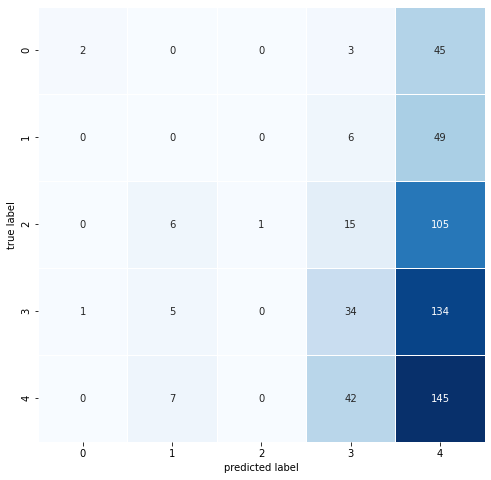

In [82]:
parameter_space = {
     'n_estimators': list(range(25,100,3)),
     'max_depth': list(range(10,35,5)),
     'max_samples': [0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28],
     'min_samples_leaf': [1,2,3],
     'criterion':['gini','entropy']    
}

grid_rfclf = RandomForestClassifier(class_weight={12.0:0.20, 11.0:0.10, 10.0:0.10, 9.0:0.30, 8.0:0.30 }, 
                                   random_state=1)
grid_clf = RandomizedSearchCV(grid_rfclf, parameter_space, n_jobs= -1, cv = 6, scoring=f1)
grid_clf.fit(monthly_train[:-1],np.array(monthly_y_star_train.iloc[1:]).ravel())
tuned_monthly_y_hat_test = grid_clf.predict(monthly_test)
tuned_monthly_y_hat_train = grid_clf.predict(monthly_train)
tuned_test_f1 = f1_score(tuned_monthly_y_hat_test, monthly_y_star_test, average='weighted')
tuned_train_f1 = f1_score(tuned_monthly_y_hat_train, monthly_y_star_train, average='weighted')


y_prob = grid_clf.predict_proba(monthly_test)
tuned_macro_roc_auc_ovo = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                        y_prob, 
                                        multi_class="ovo", 
                                        average="macro")
tuned_weighted_roc_auc_ovo = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                           y_prob, 
                                           multi_class="ovo", 
                                           average="weighted"
)
tuned_macro_roc_auc_ovr = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                        y_prob, 
                                        multi_class="ovr", 
                                        average="macro")
tuned_weighted_roc_auc_ovr = roc_auc_score(np.array(monthly_y_star_test).ravel(), 
                                           y_prob, 
                                           multi_class="ovr", 
                                           average="weighted"
)


print(f'Gridsearch Tuned \nTrain F1: {tuned_train_f1}, Test F1: {tuned_test_f1}')

print(f'\nBest parameters: {grid_clf.best_params_}')
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(tuned_macro_roc_auc_ovo, tuned_weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(tuned_macro_roc_auc_ovr, tuned_weighted_roc_auc_ovr))
plot_confusion_matrix(monthly_y_star_test, tuned_monthly_y_hat_test)

In [91]:
params = {'first_filter': [512,256], 
          'first_kernel': [3,5,7], 
          'second_filter':[512,256],       
          'second_kernel':[3,5],
          'third_filter':[512,256],       
          'third_kernel':[3],
          'batch_size':[64],
          'pooling':[1],
          'dense_nodes':[1024,512],
          'learning_rate':[.001],
          'regularization':[[True,0.001, 0.25],[True,0.001,0.4],[False, 0, 0]],
}

iter_dict = [dict(zip(params, v)) for v in product(*params.values())]
len(iter_dict)

288